## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
import seaborn as sns
import geopandas as gpd
import json
import ee

%matplotlib inline

C:\Anaconda3\envs\geo\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Start the earth engine library
ee.Initialize()

## Select the study area

In this case, are we going to use a ploygon geometry to create an area of interest. For example, a shapefile near Guanajuato, Mexico. This polygon will be used to clip the image collection. The polygon will be converted to .json and utilized as a FeatureCollection

In [65]:
# Import shapefile

# Set the file route
fp = "C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\Rancho_seco\\"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

In [4]:
# Convert the shapefile to json
aoi = data.to_json()

# load the json file
aoi = json.loads(aoi)

# Select the features
aoi = aoi['features']

aoi

[{'id': '0',
  'type': 'Feature',
  'properties': {'area': 3e-05, 'id': 0, 'perimeter': 0.023406},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-100.836501, 20.906915],
     [-100.837975, 20.912083],
     [-100.834724, 20.91543],
     [-100.831857, 20.907202],
     [-100.836501, 20.906915]]]}}]

In [5]:
# Convert the area of interest to FeatureCollection
area = ee.FeatureCollection(aoi).geometry()
area.getInfo()

{'type': 'Polygon',
 'coordinates': [[[-100.836501, 20.906915],
   [-100.831857, 20.907202],
   [-100.834724, 20.91543],
   [-100.837975, 20.912083],
   [-100.836501, 20.906915]]]}

## Select the image collection 

Select the collection **MOD17A2H.006: Terra Gross Primary Productivity 8-Day Global 500M** 

Extracted from google earth engine data catalog:

"The MOD17A2H V6 Gross Primary Productivity (GPP) product is a cumulative 8-day composite with a 500m resolution. The product is based on the radiation-use efficiency concept and can be potentially used as inputs to data models to calculate terrestrial energy, carbon, water cycle processes, and biogeochemistry of vegetation."

For more information: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A2H

### Select the time range

Define the time range based on the dataset availability

In [6]:
# Define time range
startyear = 2001
endyear = 2021

# Set the date in ee date format
start_date = ee.Date.fromYMD(startyear, 1, 1)
end_date = ee.Date.fromYMD(endyear, 12, 31)

### Import MOD17A2H collection - Gross Primary Production (GPP)

In [7]:
# Import MOD17A2H dataset
collection = ee.ImageCollection('MODIS/006/MOD17A2H')\
    .filterDate(start_date, end_date)\

# Conversion function
# This funtion is used to scale both bands and copy the properties
def conversion (img):
    return img.select(['Gpp', 'PsnNet']).multiply(0.0001).copyProperties(img, ["system:time_start"])

MOD17 = collection.map(conversion)


Print the dates of the image collection with the next function. We use the property 'system:time_start' and apply the format 'YYYY-MM-DD'. The result is a list of dates.

In [8]:
# Get the date info from the collection
dates_MOD17 = MOD17.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
print(dates_MOD17.getInfo())

['2001-01-01', '2001-01-09', '2001-01-17', '2001-01-25', '2001-02-02', '2001-02-10', '2001-02-18', '2001-02-26', '2001-03-06', '2001-03-14', '2001-03-22', '2001-03-30', '2001-04-07', '2001-04-15', '2001-04-23', '2001-05-01', '2001-05-09', '2001-05-17', '2001-05-25', '2001-06-02', '2001-06-10', '2001-06-18', '2001-07-04', '2001-07-12', '2001-07-20', '2001-07-28', '2001-08-05', '2001-08-13', '2001-08-21', '2001-08-29', '2001-09-06', '2001-09-14', '2001-09-22', '2001-09-30', '2001-10-08', '2001-10-16', '2001-10-24', '2001-11-01', '2001-11-09', '2001-11-17', '2001-11-25', '2001-12-03', '2001-12-11', '2001-12-19', '2001-12-27', '2002-01-01', '2002-01-09', '2002-01-17', '2002-01-25', '2002-02-02', '2002-02-10', '2002-02-18', '2002-02-26', '2002-03-06', '2002-03-14', '2002-03-22', '2002-03-30', '2002-04-07', '2002-04-15', '2002-04-23', '2002-05-01', '2002-05-09', '2002-05-17', '2002-05-25', '2002-06-02', '2002-06-10', '2002-06-18', '2002-06-26', '2002-07-04', '2002-07-12', '2002-07-20', '2002

Create a clip function to filter the data based in the area of interest. 

In [9]:
# Clip the ImageCollection with the area of interest and copy the date metadata
def clip (img):
    return img.clip(area).copyProperties(img, ["system:time_start"]).set('date', img.date().format('YYYY-MM-dd'))

# Appy the clip function and print a list of the properties of the collection
MOD17 = MOD17.map(clip)
MOD17.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'Gpp',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -3.2768,
    'max': 3.2767},
   'dimensions': [3, 3],
   'origin': [20592, 16580],
   'crs': 'SR-ORG:6974',
   'crs_transform': [463.3127165279165,
    0,
    -20015109.353988,
    0,
    -463.3127165274999,
    10007554.676994]},
  {'id': 'PsnNet',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -3.2768,
    'max': 3.2767},
   'dimensions': [3, 3],
   'origin': [20592, 16580],
   'crs': 'SR-ORG:6974',
   'crs_transform': [463.3127165279165,
    0,
    -20015109.353988,
    0,
    -463.3127165274999,
    10007554.676994]}],
 'properties': {'system:time_start': 978307200000,
  'date': '2001-01-01',
  'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-100.836501, 20.906915],
     [-100.831857, 20.907202],
     [-100.834724, 20.91543],
     [-100.837975, 20.912083],
     [-100.836501, 20.906915]]]},
  'system:index': '2001_01_01'}}

In [10]:
# Print the size of the collection
print(MOD17.size().getInfo())

965


### Reduce the values

Reduce the vales of each band using a mean reducer. The reduced set will contain all the properties containded in the image. 

First, we will copy the properties of each image and convert the 'system:time_start' property to a more readable format. then, the reducer will be result in an unique value that represents the mean of all the pixel values and using the function *set_properties* over the reducer, it pastes the information in each set. 


This section is based on: https://gis.stackexchange.com/questions/356646/iterating-time-series-extraction-of-all-bands-in-an-earth-engine-weather-data-se

In [11]:
# Create a function to create a table of values
def series_reducer(image):

    # Copy the properties and change the format of the date field
    def set_properties(f):
        return f.set('imageId',image.id())\
                .set('system:index',image.get('system:index'))\
                .set('system:time_start',image.get('system:time_start')).set('date', image.date().format('YYYY-MM-dd'))

    # Reducer function
    return image.reduceRegions(    
        collection=area,
        reducer=ee.Reducer.mean(),
        scale=500).map(set_properties)

# Aplly the function and sort by date
reduced_data = MOD17.map(series_reducer)\
    .flatten()\
    .sort('date', True)

# Print the first result
reduced_data.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-100.836501, 20.906915],
    [-100.831857, 20.907202],
    [-100.834724, 20.91543],
    [-100.837975, 20.912083],
    [-100.836501, 20.906915]]]},
 'id': '2001_01_01_0',
 'properties': {'Gpp': 0.0062377410468319565,
  'PsnNet': 0.0055344352617079885,
  'date': '2001-01-01',
  'imageId': '2001_01_01',
  'system:time_start': 978307200000}}

In [12]:
# Print the size of the reduced series
print(reduced_data.size().getInfo())

965


### Export the data to a dataframe

In this section, the reduced list will be converted to a pandas dataframe and exported in a .csv file. First, we create a selection of the properties **date**, **Gpp** and **PsnNet** and reduce it to a list. Then, the pandas library will be used to export this list in a geopandas dataframe

In [13]:
# Export the set to a list
Export_list = reduced_data\
    .reduceColumns(ee.Reducer.toList(3), ['date', 'Gpp', 'PsnNet']).values().get(0)

In [14]:
# Use pandas to convert the list to a dataframe
df_MOD17 = pd.DataFrame(Export_list.getInfo(), columns=['date','Gpp', 'PsnNet'])
df_MOD17

,date,Gpp,PsnNet
0,2001-01-01,0.006238,0.005534
1,2001-01-09,0.007166,0.006423
2,2001-01-17,0.007239,0.006428
3,2001-01-25,0.008116,0.007248
4,2001-02-02,0.007256,0.006538
...,...,...,...
960,2021-11-25,0.014139,0.012386
961,2021-12-03,0.013471,0.011693
962,2021-12-11,0.011379,0.009981
963,2021-12-19,0.011829,0.010218


In [15]:
# Export the table to csv

# directory route
fp = 'C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\MOD17_table.csv'

export_MOD17 = df_MOD17.to_csv(fp)

### Create MR field 

In this section, we´ll create a new field called Maintenance Respiration(MR) based on Gpp and PsnNet. The next formula is used to get this field:

 $$MR = Gpp - PsnNet$$
 
 Also, a cummulative sum of Gross Primary Production field will be created.

In [32]:
# Read .csv data
df_carbon = pd.read_csv('C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\MOD17_table.csv')
df_carbon

,Unnamed: 0,date,Gpp,PsnNet
0,0,2001-01-01,0.006238,0.005534
1,1,2001-01-09,0.007166,0.006423
2,2,2001-01-17,0.007239,0.006428
3,3,2001-01-25,0.008116,0.007248
4,4,2001-02-02,0.007256,0.006538
...,...,...,...,...
960,960,2021-11-25,0.014139,0.012386
961,961,2021-12-03,0.013471,0.011693
962,962,2021-12-11,0.011379,0.009981
963,963,2021-12-19,0.011829,0.010218


In [35]:
# Format 'date' to datetime data

# convert the 'Date' column to datetime format
df_carbon['date']= pd.to_datetime(df_carbon['date'])
 
# Check the format of 'Date' column
df_carbon.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  965 non-null    int64         
 1   date        965 non-null    datetime64[ns]
 2   Gpp         965 non-null    float64       
 3   PsnNet      965 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 30.3 KB


In [36]:
# Create the MR field using the formula described above
df_carbon['MR'] = df_carbon['Gpp'] - df_carbon['PsnNet']
df_carbon

,Unnamed: 0,date,Gpp,PsnNet,MR
0,0,2001-01-01,0.006238,0.005534,0.000703
1,1,2001-01-09,0.007166,0.006423,0.000743
2,2,2001-01-17,0.007239,0.006428,0.000810
3,3,2001-01-25,0.008116,0.007248,0.000868
4,4,2001-02-02,0.007256,0.006538,0.000718
...,...,...,...,...,...
960,960,2021-11-25,0.014139,0.012386,0.001753
961,961,2021-12-03,0.013471,0.011693,0.001779
962,962,2021-12-11,0.011379,0.009981,0.001399
963,963,2021-12-19,0.011829,0.010218,0.001610


The cumulative sum is created using the *.cumsum()* function

In [37]:
# Create the cummulative sum using .cumsum() function
df_carbon['Gpp_sum'] = df_carbon['Gpp'].cumsum()
df_carbon

# Units in kg*C/m^2

,Unnamed: 0,date,Gpp,PsnNet,MR,Gpp_sum
0,0,2001-01-01,0.006238,0.005534,0.000703,0.006238
1,1,2001-01-09,0.007166,0.006423,0.000743,0.013404
2,2,2001-01-17,0.007239,0.006428,0.000810,0.020643
3,3,2001-01-25,0.008116,0.007248,0.000868,0.028758
4,4,2001-02-02,0.007256,0.006538,0.000718,0.036015
...,...,...,...,...,...,...
960,960,2021-11-25,0.014139,0.012386,0.001753,16.311575
961,961,2021-12-03,0.013471,0.011693,0.001779,16.325047
962,962,2021-12-11,0.011379,0.009981,0.001399,16.336426
963,963,2021-12-19,0.011829,0.010218,0.001610,16.348255


### Create a plot

Text(0.5, 1.0, 'Gross Primary Production (GPP) in Rancho Seco, Guanajuato')

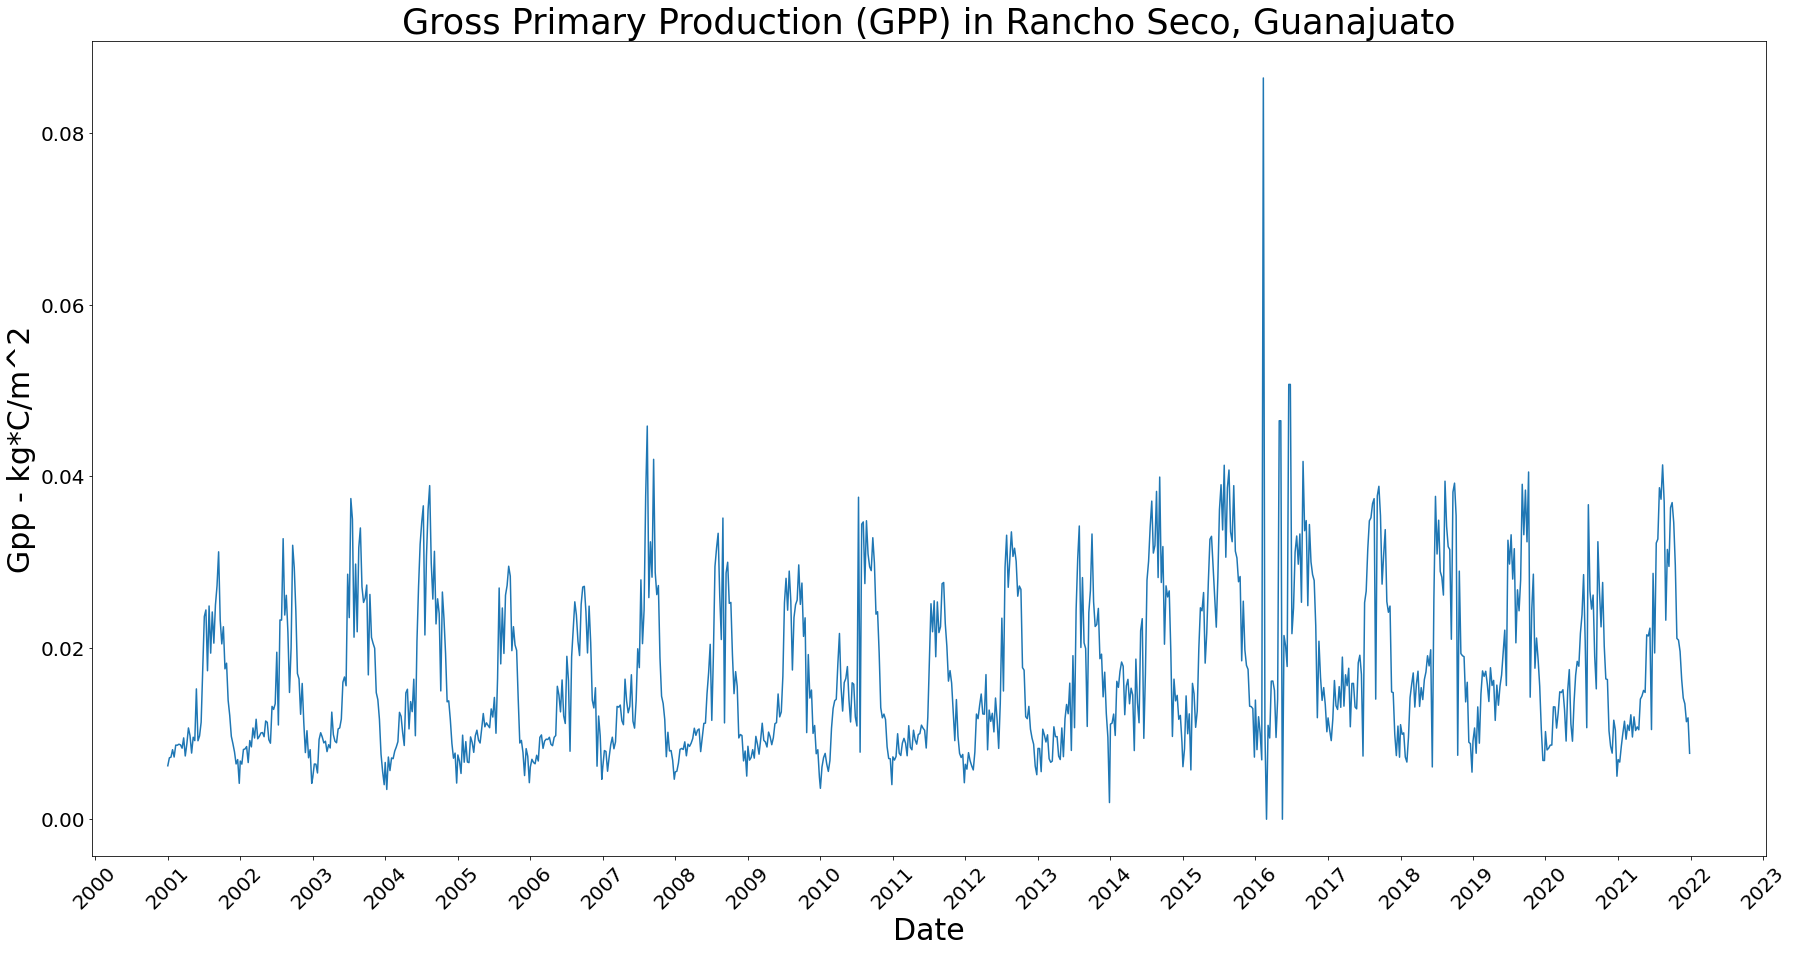

In [51]:
# Import matplotlib libraries required for date formatting
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Create a plot with the dataframe
fig, ax = plt.subplots(1,1,figsize=(30, 15))

# Use 'rainfall_mean' and 'month' to create a plot
sns.lineplot(data = df_carbon, x = 'date', y = 'Gpp')

# plot tiles
ax.set_ylabel('Gpp - kg*C/m^2', fontsize = 30)
ax.set_xlabel('Date', fontsize = 30)
plt.xticks(rotation = 45)

# Change the tick size
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1))


ax.set_title('Gross Primary Production (GPP) in Rancho Seco, Guanajuato', fontsize = 35)

### Interactive Plotting

In [60]:
# Import plotly library
import altair as alt

# Creating a plot
alt.Chart(df_carbon).mark_line().encode(
    x = alt.X('date', title = 'Date'),
    y = 'Gpp:Q',
    
    
    tooltip = [
        alt.Tooltip('date:T', title = 'date'),
        alt.Tooltip('Gpp:Q')
        ]).properties(width = 600, height = 300).interactive()

alt.Chart(...)